### Imports and load the data

In [20]:
from showupforhealth.utils import perform_train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 40)
import numpy as np
from imblearn.over_sampling import SMOTE
import time
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.metrics import Recall
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
from sklearn.metrics import f1_score
import keras_tuner as kt
from showupforhealth.ml_functions.predict import make_predict
from showupforhealth.utils import fit_scaler, transform_data

### ECS test - COMMENTED

In [83]:
# ecs_data = make_predict()

In [75]:
# ecs_data = ecs_data[X_train_cols_lst]
# ecs_data.head(3)

In [76]:
# X_train.head(3)

In [77]:
# X_train_cols_lst = X_train.columns.tolist()
# X_train_cols_lst

In [78]:
# global_scaler = fit_scaler(X_train)

In [80]:
# ecs_scaled = transform_data(ecs_data, global_scaler)
# ecs_scaled

In [81]:
# pred_df = pd.DataFrame(model_kt_1.predict(ecs_scaled))
# pred_df

# DL model

### Load and shuffle the data

In [2]:
data = pd.read_csv('/Users/alessio/code/janduplessis883/data-showup/data/output-data/full_train_data.csv')

In [3]:
data

,Appointment_status,Patient ID,temp,precipitation,Age,Sex,FRAILTY,DEPRESSION,OBESITY,IHD,DM,HPT,NDHG,SMI,IMD2023,dist_to_station,distance_to_surg,book_to_app_days,booked_by_clinician,registered_for_months,sin_week,cos_week,sin_Appointment_time,cos_Appointment_time,sin_month,cos_month,sin_day_of_week,cos_day_of_week,No_shows,Rota_ARRS,Rota_GP,Rota_HCA,Rota_Nurse,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Mixed,Ethnicity_Other,Ethnicity_White
0,1.0,19580589.0,17.7,0.0,40.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22698.0,0.519419,0.816996,54.0,1.0,17.0,-0.120537,-0.992709,7.071068e-01,-0.707107,-5.000000e-01,-0.866025,0.781831,0.623490,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,47551135.0,18.5,0.0,70.0,1.0,0.39,0.0,1.0,0.0,1.0,1.0,0.0,0.0,10169.0,0.540792,1.656309,49.0,0.0,12.0,-0.120537,-0.992709,5.000000e-01,-0.866025,-5.000000e-01,-0.866025,0.781831,0.623490,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,1.0,19579593.0,19.4,0.0,66.0,1.0,0.03,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8243.0,0.332691,0.600495,37.0,0.0,70.0,-0.120537,-0.992709,2.588190e-01,-0.965926,-5.000000e-01,-0.866025,0.433884,-0.900969,10.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,19581430.0,18.3,0.0,58.0,0.0,0.11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7626.0,0.155802,0.215224,27.0,0.0,28.0,-0.120537,-0.992709,7.071068e-01,-0.707107,-5.000000e-01,-0.866025,0.433884,-0.900969,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,17407665.0,27.7,0.0,61.0,0.0,0.06,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8087.0,0.451039,4.237312,38.0,0.0,30.0,-0.354605,-0.935016,7.071068e-01,-0.707107,-5.000000e-01,-0.866025,0.000000,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595262,1.0,31125126.0,7.6,0.0,68.0,0.0,0.17,1.0,0.0,0.0,0.0,1.0,0.0,0.0,28809.0,0.424582,2.643645,1.0,0.0,9.0,0.120537,0.992709,5.000000e-01,-0.866025,-2.449294e-16,1.000000,0.781831,0.623490,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
595263,1.0,47491715.0,8.5,0.0,51.0,0.0,0.06,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12935.0,0.402335,1.265651,1.0,0.0,20.0,0.120537,0.992709,2.588190e-01,-0.965926,-2.449294e-16,1.000000,0.781831,0.623490,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
595264,1.0,47491716.0,8.5,0.0,68.0,1.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12935.0,0.402335,1.265651,1.0,0.0,20.0,0.120537,0.992709,2.588190e-01,-0.965926,-2.449294e-16,1.000000,0.781831,0.623490,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
595265,1.0,47490525.0,8.5,0.0,75.0,1.0,0.19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,15885.0,0.406034,1.900980,1.0,0.0,20.0,0.120537,0.992709,2.588190e-01,-0.965926,-2.449294e-16,1.000000,0.781831,0.623490,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
data_DNA = data[data['Appointment_status']==0]
data_DNA.shape

(21909, 38)

In [5]:
data_NOT_DNA = data[data['Appointment_status']==1][:100000]
data_NOT_DNA.shape

(100000, 38)

In [6]:
data_balanced = pd.concat([data_DNA, data_NOT_DNA]).sample(frac = 1)
data_balanced['Appointment_status'].value_counts()

1.0    100000
0.0     21909
Name: Appointment_status, dtype: int64

In [7]:
data_balanced.head()

,Appointment_status,Patient ID,temp,precipitation,Age,Sex,FRAILTY,DEPRESSION,OBESITY,IHD,DM,HPT,NDHG,SMI,IMD2023,dist_to_station,distance_to_surg,book_to_app_days,booked_by_clinician,registered_for_months,sin_week,cos_week,sin_Appointment_time,cos_Appointment_time,sin_month,cos_month,sin_day_of_week,cos_day_of_week,No_shows,Rota_ARRS,Rota_GP,Rota_HCA,Rota_Nurse,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Mixed,Ethnicity_Other,Ethnicity_White
39313,1.0,17412934.0,9.3,0.0,60.0,0.0,0.14,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15761.0,0.390297,10.790996,0.0,0.0,13.0,-0.464723,0.885456,-8.660254e-01,-0.500000,-0.500000,8.660254e-01,-0.433884,-0.900969,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
33502,1.0,24352255.0,8.1,0.0,38.0,1.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28139.0,0.954623,2.058936,2.0,0.0,5.0,0.748511,0.663123,-8.660254e-01,-0.500000,0.866025,5.000000e-01,0.433884,-0.900969,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21934,1.0,17412960.0,11.2,0.0,80.0,0.0,0.44,0.0,0.0,1.0,1.0,1.0,0.0,0.0,18346.0,0.233295,0.302177,1.0,0.0,48.0,0.120537,0.992709,5.000000e-01,-0.866025,0.500000,8.660254e-01,0.433884,-0.900969,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
50410,1.0,17438179.0,20.7,0.0,58.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27528.0,0.789074,0.584343,8.0,0.0,36.0,-0.885456,-0.464723,-7.071068e-01,-0.707107,-1.000000,-1.836970e-16,0.433884,-0.900969,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97304,1.0,47527249.0,20.8,0.0,75.0,0.0,0.36,0.0,1.0,1.0,0.0,0.0,1.0,0.0,25957.0,0.733012,0.677071,1.0,0.0,9.0,-0.992709,-0.120537,1.224647e-16,-1.000000,-1.000000,-1.836970e-16,0.433884,-0.900969,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Split in X and y

In [8]:
X = data_balanced.drop(columns=['Appointment_status', 'Patient ID'])
y = data_balanced['Appointment_status']

### Baseline accuracy

In [9]:
print(f'The baseline accuracy if we assume that all patients will show-up is {y.value_counts()[1] / X.shape[0]}')

The baseline accuracy if we assume that all patients will show-up is 0.8202839823146774


### Split in Train and Test

In [10]:
X_train, X_test, y_train, y_test = perform_train_test_split(X,y)

✅ OUTPUT: X_train, X_test, y_train, y_test
Train Set:  X_train, y_train - (97527, 36), (97527,)
 Test Set:  X_test, y_test - - (24382, 36), (24382,)


### RandomUnderSampler - COMMENTED

In [19]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(sampling_strategy=0.3)

# X_train_u, y_train_u = rus.fit_resample(X_train, y_train)

# y_train_u.value_counts()

### Scale X_train and X_test - COMMENTED

In [97]:
# def mm_scaler(X_train, X_test):
#     scaler = MinMaxScaler()
#     scaler.fit(X_train)
#     X_train_scaled = scaler.transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
#     return X_train_scaled, X_test_scaled

# X_train_scaled, X_test_scaled = mm_scaler(X_train, X_test)

### Global Scaler

In [11]:
global_scaler = fit_scaler(X_train)
X_train_scaled = transform_data(X_train, global_scaler)
X_test_scaled = transform_data(X_test, global_scaler)

### Split Train and Validation

In [12]:
X_train_val, X_val, y_train_val, y_val = perform_train_test_split(X_train_scaled, y_train)

✅ OUTPUT: X_train, X_test, y_train, y_test
Train Set:  X_train, y_train - (78021, 36), (78021,)
 Test Set:  X_test, y_test - - (19506, 36), (19506,)


# Model

In [13]:
metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.AUC(name='auc')]

2023-09-16 12:58:43.626643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model 1

In [14]:
%%time
model_one = Sequential()
es = EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)

model_one.add(layers.Dense(112, activation='relu', input_dim=X.shape[1]))
model_one.add(layers.Dropout(0.2))
model_one.add(layers.Dense(32, activation='relu'))
model_one.add(layers.Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model_one.compile(loss='binary_crossentropy', optimizer=adam, metrics=metrics)

history_one = model_one.fit(X_train_val, y_train_val, validation_data=(X_val, y_val),
                    batch_size=32,
                    epochs=300,
                    shuffle=True,
                    verbose=0,
                    callbacks=[es])

results = model_one.evaluate(X_test_scaled, y_test)
print(f'Model {model_one.metrics_names[0]} is {results[0]}')
print(f'Model {model_one.metrics_names[1]} is {results[1]}')
print(f'Model {model_one.metrics_names[2]} is {results[2]}')
print(f'Model {model_one.metrics_names[3]} is {results[3]}')
print(f'Model {model_one.metrics_names[4]} is {results[4]}')

762/762 [==============================] - 1s 1ms/step - loss: 0.2240 - accuracy: 0.9046 - recall: 0.9701 - precision: 0.9180 - auc: 0.9403
Model loss is 0.22395670413970947
Model accuracy is 0.9045607447624207
Model recall is 0.9700812101364136
Model precision is 0.9179589152336121
Model auc is 0.940287172794342
CPU times: user 4min 43s, sys: 47.3 s, total: 5min 31s
Wall time: 3min 23s


In [27]:
model_one_pred = model_one.predict(X_test_scaled)
model_one_pred = (model_one_pred > 0.5).astype(np.float32)
model_one_pred

762/762 [==============================] - 1s 996us/step


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

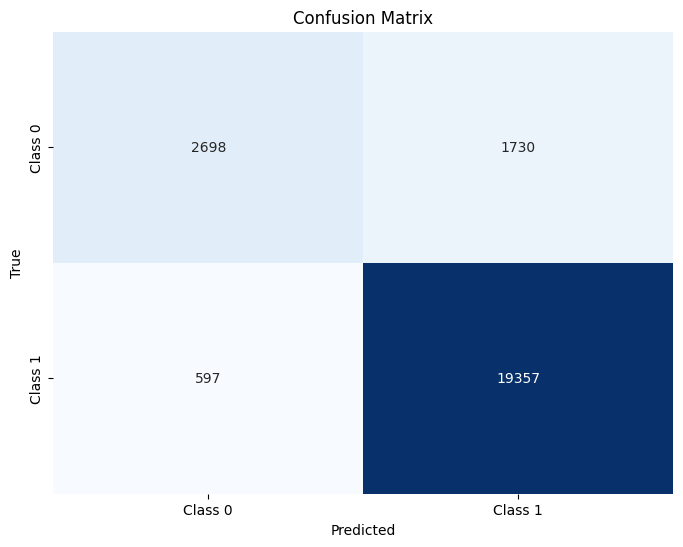

In [28]:
confusion = confusion_matrix(y_test, model_one_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


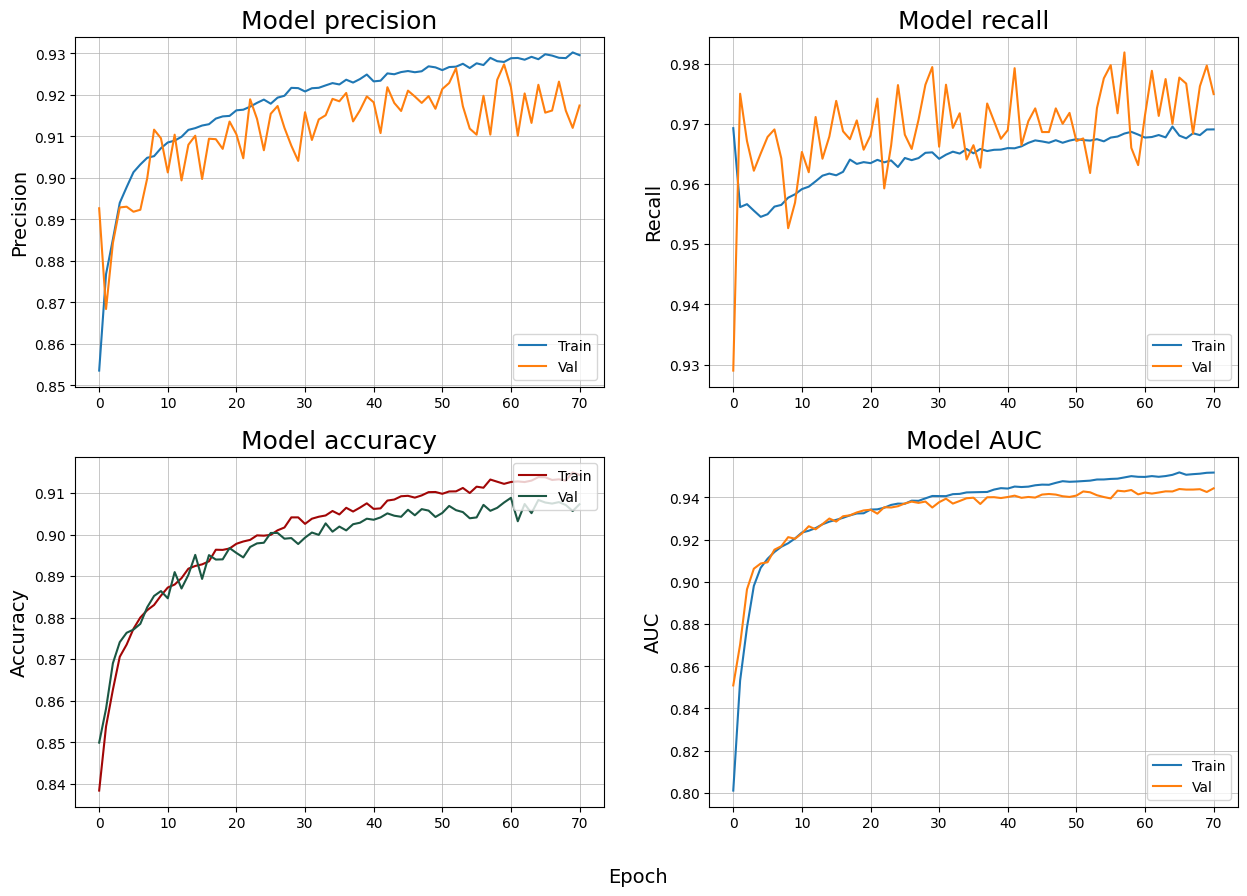

In [17]:
plot_loss_precision_recall_curve(history_one)

### Plot curves function

In [16]:
def plot_loss_precision_recall_curve(history):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

        # --- ACCURACY 
    ax[1, 0].plot(history.history['accuracy'], color="#a10606")
    ax[1, 0].plot(history.history['val_accuracy'], color="#1b5743")
    ax[1, 0].set_title('Model accuracy', fontsize = 18)
    ax[1, 0].set_ylabel('Accuracy', fontsize = 14)
    ax[1, 0].legend(['Train', 'Val'], loc='upper right')
    ax[1, 0].grid(axis="x", linewidth=0.5)
    ax[1, 0].grid(axis="y", linewidth=0.5)
    
    # --- LOSS 
#     ax[0, 0].plot(history.history['loss'], color="#a10606")
#     ax[0, 0].plot(history.history['val_loss'], color="#1b5743")
#     ax[0, 0].set_title('Model loss', fontsize = 18)
#     ax[0, 0].set_ylabel('Loss', fontsize = 14)
#     ax[0, 0].legend(['Train', 'Val'], loc='upper right')
#     ax[0, 0].grid(axis="x", linewidth=0.5)
#     ax[0, 0].grid(axis="y", linewidth=0.5)

#     --- RECALL
    ax[0, 1].plot(history.history['recall']) 
    ax[0, 1].plot(history.history['val_recall'])
    ax[0, 1].set_title('Model recall', fontsize = 18)
    ax[0, 1].set_ylabel('Recall', fontsize = 14) 
    ax[0, 1].legend(['Train', 'Val'], loc='lower right')
    ax[0, 1].grid(axis="x", linewidth=0.5)
    ax[0, 1].grid(axis="y", linewidth=0.5)

#     --- PRECISION
    ax[0,0].plot(history.history['precision'])
    ax[0,0].plot(history.history['val_precision'])
    ax[0,0].set_title('Model precision', fontsize = 18)
    ax[0,0].set_ylabel('Precision', fontsize = 14)
    ax[0,0].legend(['Train', 'Val'], loc='lower right')
    ax[0,0].grid(axis="x", linewidth=0.5)
    ax[0,0].grid(axis="y", linewidth=0.5)
    
    # --- AUC
    ax[1, 1].plot(history.history['auc'])
    ax[1, 1].plot(history.history['val_auc'])
    ax[1, 1].set_title('Model AUC', fontsize = 18) 
    ax[1, 1].set_ylabel('AUC', fontsize = 14)
    ax[1, 1].legend(['Train', 'Val'], loc='lower right')
    ax[1, 1].grid(axis="x", linewidth=0.5)
    ax[1, 1].grid(axis="y", linewidth=0.5)

    # Set common labels  
    fig.text(0.5, 0.04, 'Epoch', ha='center', va='center', fontsize=14) 
    plt.show()

### Keras tuner Model 1

In [22]:
def model_builder(hp):
    model = Sequential()
    # hp
    hp_units_1 = hp.Int('units_1', min_value=16, max_value=128, step=16)
    hp_units_2 = hp.Int('units_2', min_value=16, max_value=128, step=16)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
    hp_dropout = hp.Choice('learning_rate', values=[0.1, 0.2, 0.3])

    # Layers
    model.add(layers.Dense(units=hp_units_1, activation='relu', input_dim=X.shape[1]))
    model.add(layers.Dropout(rate=hp_dropout))
    model.add(layers.Dense(units=hp_units_2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compiler
    adam = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=metrics)

    return model

In [23]:
LOG_DIR = f'{int(time.time())}'
tuner_kt_1 = kt.RandomSearch(model_builder,
                     objective=kt.Objective('val_auc', direction="max"),
                     directory=LOG_DIR)

stop_early = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True)
                     
tuner_kt_1.search(X_train_val, y_train_val, validation_data=(X_val, y_val),
             epochs=100,
             callbacks=[stop_early])

Trial 10 Complete [00h 01m 48s]
val_auc: 0.9684964418411255

Best val_auc So Far: 0.969912588596344
Total elapsed time: 00h 20m 25s
INFO:tensorflow:Oracle triggered exit


In [24]:
best_hps=tuner_kt_1.get_best_hyperparameters(num_trials=1)[0]
best_hps.__dict__

{'_name_scopes': [],
 '_conditions': [],
 '_hps': defaultdict(list,
             {'units_1': [Int(name: 'units_1', min_value: 16, max_value: 128, step: 16, sampling: linear, default: 16)],
              'units_2': [Int(name: 'units_2', min_value: 16, max_value: 128, step: 16, sampling: linear, default: 16)],
              'learning_rate': [Choice(name: 'learning_rate', values: [0.1, 0.01, 0.001], ordered: True, default: 0.1)]}),
 '_space': [Int(name: 'units_1', min_value: 16, max_value: 128, step: 16, sampling: linear, default: 16),
  Int(name: 'units_2', min_value: 16, max_value: 128, step: 16, sampling: linear, default: 16),
  Choice(name: 'learning_rate', values: [0.1, 0.01, 0.001], ordered: True, default: 0.1)],
 'values': {'units_1': 112, 'units_2': 32, 'learning_rate': 0.001},
 'active_scopes': [],
 'inactive_scopes': []}

In [25]:
es = EarlyStopping(patience=20, monitor='val_auc', restore_best_weights=True)
model_kt_1 = tuner_kt_1.hypermodel.build(best_hps)
history_kt_1 = model_kt_1.fit(X_train_val, y_train_val, validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    verbose=0,
                    callbacks=[es])

In [26]:
model_kt_1.evaluate(X_test_scaled, y_test)

387/387 [==============================] - 0s 1ms/step - loss: 0.2067 - accuracy: 0.9188 - recall: 0.9449 - precision: 0.9295 - auc: 0.9718


[0.20673628151416779,
 0.9187530279159546,
 0.9449414014816284,
 0.9294832348823547,
 0.9718455076217651]

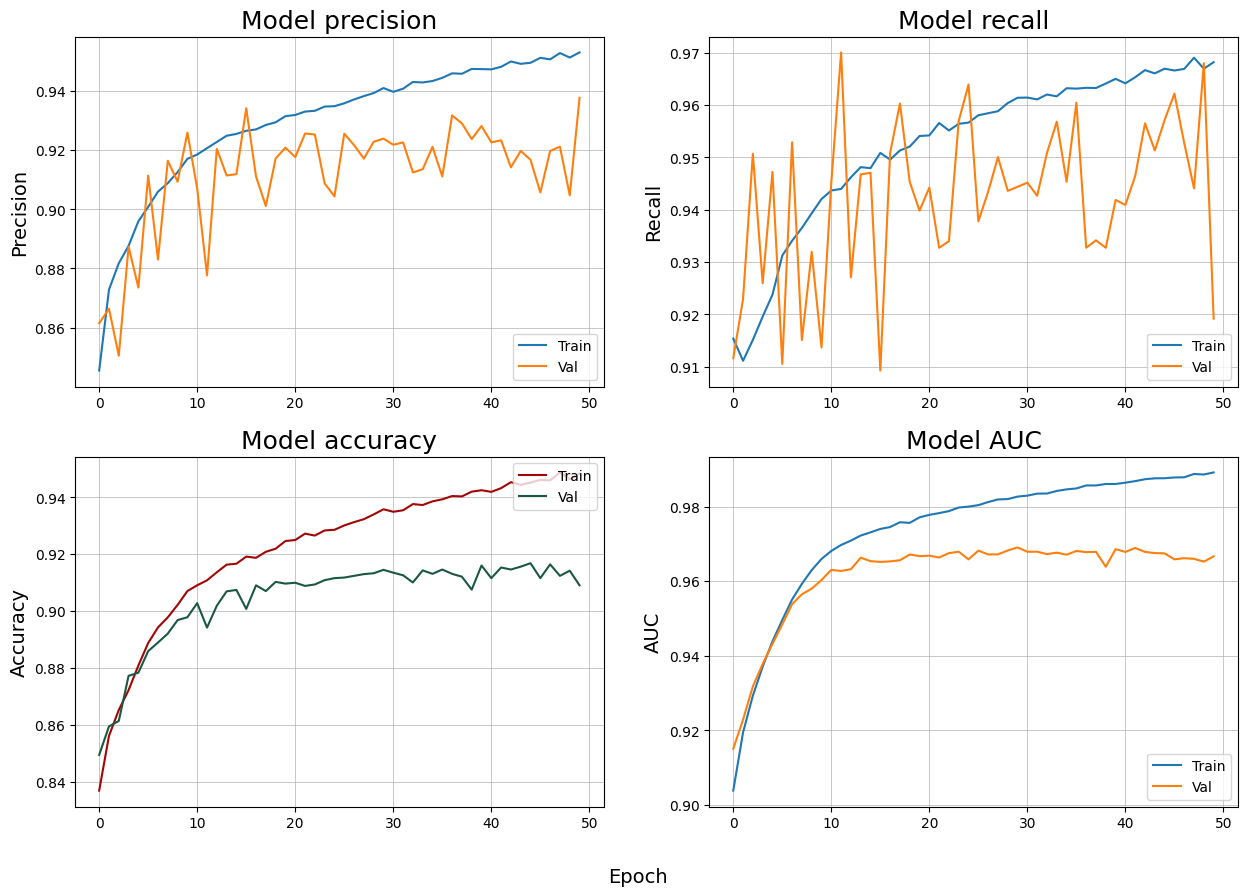

In [29]:
plot_loss_precision_recall_curve(history_kt_1)